In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import expit  # Vectorized sigmoid function
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/MyDrive/CS289/hw4/data.mat'
data = scipy.io.loadmat(data_path)
data_keys = [k for k in data.keys() if not k.startswith('__')]
print(f'Actual data keys: {data_keys}')

# Inspect each key
for key in data_keys:
  print(f'\n{key}:')
  print(f'  Shape: {data[key].shape}')
  print(f'  Type: {data[key].dtype}')
  if len(data[key].shape) == 1:
    print(f'  Unique values: {np.unique(data[key])}')
  else:
    print(f'  Sample values (first 3 rows): ')
    print(data[key][:3])

Actual data keys: ['y', 'X', 'description', 'X_test']

y:
  Shape: (5000, 1)
  Type: float64
  Sample values (first 3 rows): 
[[1.]
 [0.]
 [1.]]

X:
  Shape: (5000, 12)
  Type: float64
  Sample values (first 3 rows): 
[[8.6000e+00 4.2000e-01 3.9000e-01 1.8000e+00 6.8000e-02 6.0000e+00
  1.2000e+01 9.9516e-01 3.3500e+00 6.9000e-01 1.1700e+01 8.0000e-01]
 [8.2000e+00 3.0000e-01 4.4000e-01 1.2400e+01 4.3000e-02 5.2000e+01
  1.5400e+02 9.9452e-01 3.0400e+00 3.3000e-01 1.2000e+01 6.0000e-01]
 [1.0800e+01 3.2000e-01 4.4000e-01 1.6000e+00 6.3000e-02 1.6000e+01
  3.7000e+01 9.9850e-01 3.2200e+00 7.8000e-01 1.0000e+01 6.0000e-01]]

description:
  Shape: (12,)
  Type: <U20
  Unique values: ['alcohol             ' 'chlorides           ' 'citric acid         '
 'density             ' 'fixed acidity       ' 'free sulfur dioxide '
 'pH                  ' 'quality             ' 'residual sugar      '
 'sulphates           ' 'total sulfur dioxide' 'volatile acidity    ']

X_test:
  Shape: (1000, 12)
 

In [3]:
from typing import Tuple

X, y, X_test = data['X'], data['y'], data['X_test']

def preprocess(X: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  X_mean = np.mean(X, axis=0)
  X_std = np.std(X, axis=0)
  X_normalized = (X - X_mean) / X_std
  X_processed = np.hstack([np.ones((X_normalized.shape[0], 1)), X_normalized])
  X_test_normalized = (X_test - X_mean) / X_std
  X_test_processed = np.hstack([np.ones((X_test_normalized.shape[0], 1)), X_test_normalized])

  return (X_processed, X_test_processed)

In [7]:
class LogisticRegression():
  def __init__(self, learning_rate: float, lam: float, max_iters: int):
    self.learning_rate = learning_rate
    self.lam = lam
    self.max_iters = max_iters
    self.weights = None
    self.cost_history = []

  def fit_batch(self, X: np.ndarray, y: np.ndarray):
    n_samples, n_features = X.shape
    w = np.random.normal(0, 0.01, n_features)

    for i in range(self.max_iters):
      z = X @ w
      y_pred = expit(z)
      y_diff = y_pred - y.flatten()

      # Calculate cost
      epsilon = 1e-9
      cost = -np.mean(y.flatten() * np.log(y_pred + epsilon) + (1-y.flatten()) * np.log(1 - y_pred + epsilon))
      l2_reg = (self.lam / 2) * np.sum(np.square(w[1:]))
      self.cost_history.append(cost + l2_reg)

      dfw = (1 / n_samples) * X.T @ y_diff
      # Add regularization to the gradient update
      dfw[1:] += self.lam * w[1:]
      w -= self.learning_rate * dfw

    self.weights = w

  def fit_sgd(self, X: np.ndarray, y: np.ndarray):
    n_samples, n_features = X.shape
    self.weights = np.random.normal(0, 0.01, n_features)

    for i in range(self.max_iters):
      indices = np.arange(n_samples)
      np.random.shuffle(indices)
      for idx in indices:
        X_i = X[idx: idx + 1]
        y_i = y[idx: idx + 1]
        z = X_i @ self.weights
        y_pred = expit(z)
        y_diff = y_pred - y_i.flatten()
        dfw = X_i.T @ y_diff
        dfw[1:] += self.lam * self.weights[1:]
        self.weights -= self.learning_rate * dfw
      full_pred = expit(X @ self.weights)
      epsilon = 1e-9
      cost = -np.mean(y.flatten() * np.log(full_pred + epsilon) + (1-y.flatten()) * np.log(1 - full_pred + epsilon))
      l2_reg = (self.lam / 2) * np.sum(np.square(self.weights[1:]))
      self.cost_history.append(cost + l2_reg)


  def predict_proba(self, X: np.ndarray) -> np.ndarray:
    return expit(X @ self.weights)

  def predict(self, X: np.ndarray) -> np.ndarray:
    logits = X @ self.weights
    return (logits >= 0).astype(int)

In [5]:
from typing import Union, Optional

def shuffle_and_split(
    X: np.ndarray,
    y: np.ndarray,
    validation_size: Union[float, int] = 0.2,
    seed: Optional[int] = 1
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if X.shape[0] != y.shape[0]:
        raise ValueError('data shape error')

    n_sample = X.shape[0]

    rng = np.random.default_rng(seed=seed)
    shuffled_indices = rng.permutation(n_sample)

    X_shuffle = X[shuffled_indices]
    y_shuffle = y[shuffled_indices]

    if isinstance(validation_size, float):
        if not (0.0 <= validation_size <= 1.0):
            raise ValueError('split percentage error')
        split_index = int(n_sample * (1 - validation_size))
    elif isinstance(validation_size, int):
        if not(0 <= validation_size <= n_sample):
            raise ValueError('validation data size error')
        split_index = n_sample - validation_size

    X_train = X_shuffle[:split_index]
    y_train = y_shuffle[:split_index]
    X_val = X_shuffle[split_index:]
    y_val = y_shuffle[split_index:]

    return X_train, X_val, y_train, y_val

LR: 0.1, Lambda: 0.1, Val Accuracy: 0.9840
LR: 0.1, Lambda: 0.01, Val Accuracy: 0.9920
LR: 0.1, Lambda: 0.001, Val Accuracy: 0.9920
LR: 0.01, Lambda: 0.1, Val Accuracy: 0.9770
LR: 0.01, Lambda: 0.01, Val Accuracy: 0.9700
LR: 0.01, Lambda: 0.001, Val Accuracy: 0.9700
LR: 0.001, Lambda: 0.1, Val Accuracy: 0.9560
LR: 0.001, Lambda: 0.01, Val Accuracy: 0.9580
LR: 0.001, Lambda: 0.001, Val Accuracy: 0.9440

Best BGD Params: {'learning_rate': 0.1, 'lambda': 0.01} with Val Accuracy: 0.9920


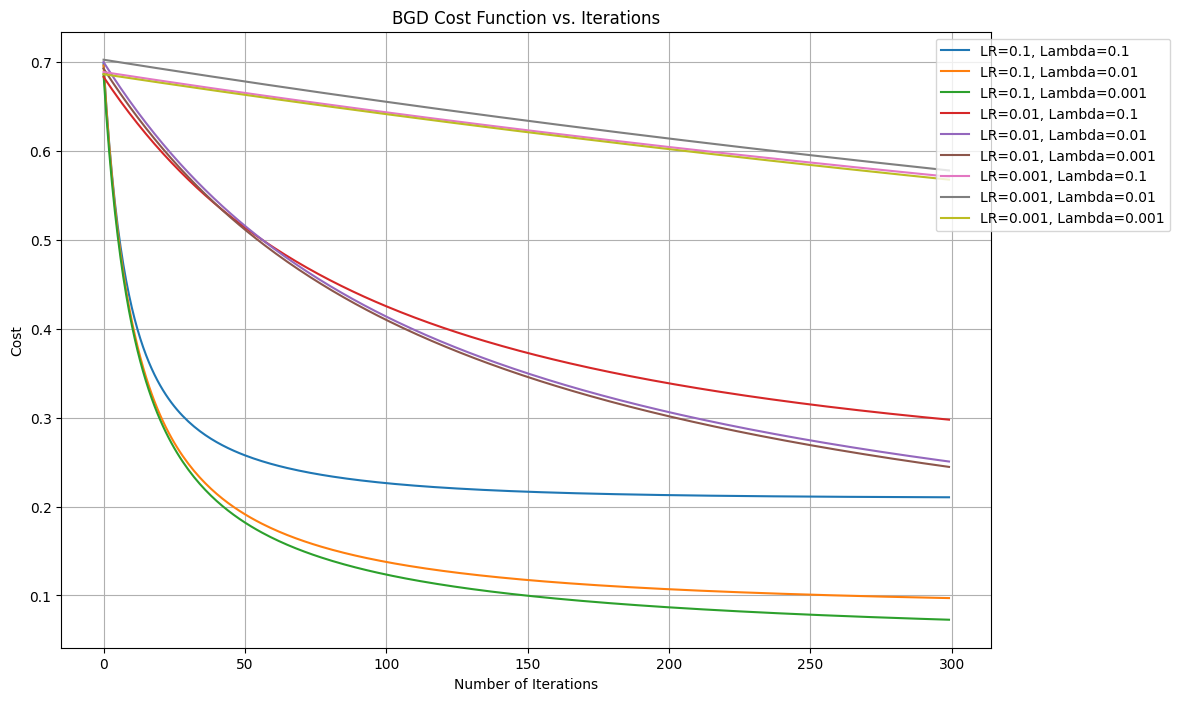


--- Tuning for Stochastic Gradient Descent ---
LR: 0.01, Lambda: 0.1, Val Accuracy: 0.9770
LR: 0.01, Lambda: 0.01, Val Accuracy: 0.9920
LR: 0.01, Lambda: 0.001, Val Accuracy: 0.9930
LR: 0.001, Lambda: 0.1, Val Accuracy: 0.9800
LR: 0.001, Lambda: 0.01, Val Accuracy: 0.9920
LR: 0.001, Lambda: 0.001, Val Accuracy: 0.9930
LR: 0.0001, Lambda: 0.1, Val Accuracy: 0.9810
LR: 0.0001, Lambda: 0.01, Val Accuracy: 0.9920
LR: 0.0001, Lambda: 0.001, Val Accuracy: 0.9930

Best SGD Params: {'learning_rate': 0.01, 'lambda': 0.001} with Val Accuracy: 0.9930


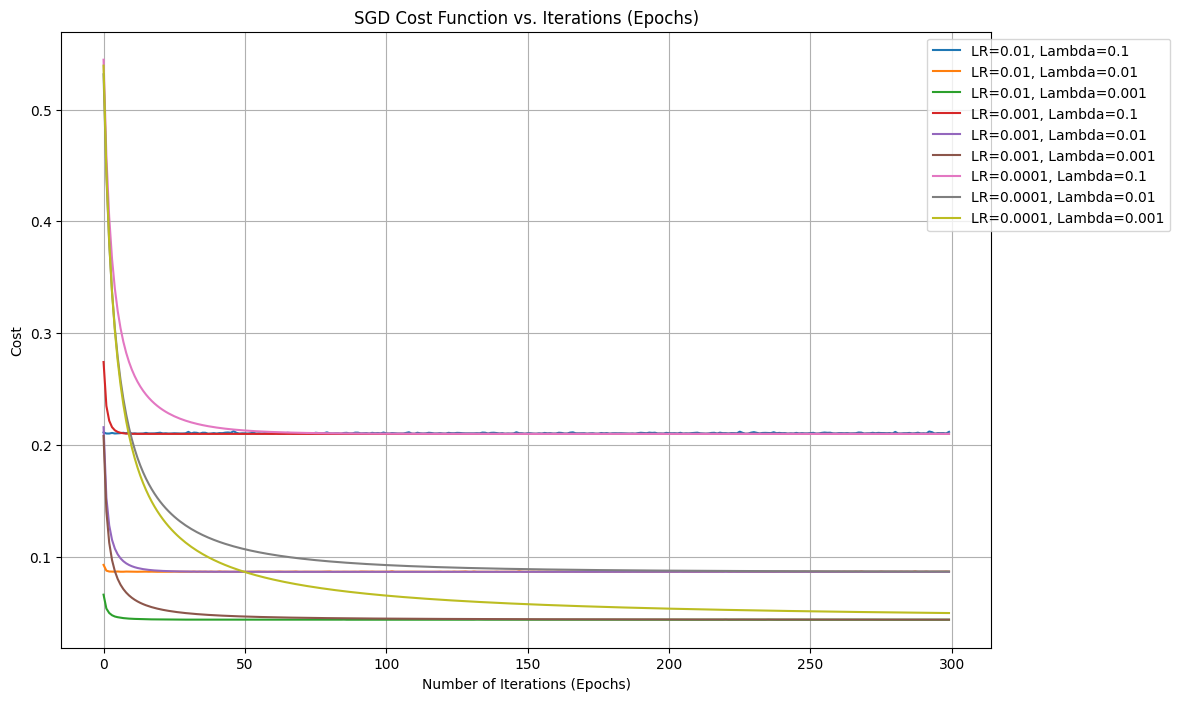

In [11]:
# Use both batch and sgd for training
learning_rates = [0.1, 0.01, 0.001]
lambdas = [0.1, 0.01, 0.001]
max_iters = 300
best_params_bgd = {}
best_val_acc_bgd = -1

X_train, X_val, y_train, y_val = shuffle_and_split(X, y)
X_train_processed, X_val_processed = preprocess(X_train, X_val)

plt.figure(figsize=(12, 8))  # Create a new figure for BGD

for lr in learning_rates:
    for lam in lambdas:
        model = LogisticRegression(learning_rate=lr, lam=lam, max_iters=max_iters)
        model.fit_batch(X_train_processed, y_train)
        val_acc = np.mean(model.predict(X_val_processed) == y_val.flatten())
        print(f"LR: {lr}, Lambda: {lam}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc_bgd:
            best_val_acc_bgd = val_acc
            best_params_bgd = {'learning_rate': lr, 'lambda': lam}

        # Plot the cost curve for the current hyperparameter combination
        plt.plot(range(max_iters), model.cost_history, label=f"LR={lr}, Lambda={lam}")

print(f"\nBest BGD Params: {best_params_bgd} with Val Accuracy: {best_val_acc_bgd:.4f}")

# Configure and display the plot for BGD
plt.title('BGD Cost Function vs. Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))  # Move legend to the right to avoid obscuring curves
plt.grid(True)
plt.show()


# The same for SGD (SGD usually needs smaller learning rate)
learning_rates_sgd = [0.01, 0.001, 0.0001]
best_params_sgd = {}
best_val_acc_sgd = -1

print("\n--- Tuning for Stochastic Gradient Descent ---")
plt.figure(figsize=(12, 8))  # Create a new figure for SGD

for lr in learning_rates_sgd:
    for lam in lambdas:
        model = LogisticRegression(learning_rate=lr, lam=lam, max_iters=max_iters)
        model.fit_sgd(X_train_processed, y_train)
        val_acc = np.mean(model.predict(X_val_processed) == y_val.flatten())
        print(f"LR: {lr}, Lambda: {lam}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc_sgd:
            best_val_acc_sgd = val_acc
            best_params_sgd = {'learning_rate': lr, 'lambda': lam}

        # Plot the cost curve for the current hyperparameter combination
        plt.plot(range(max_iters), model.cost_history, label=f"LR={lr}, Lambda={lam}")

print(f"\nBest SGD Params: {best_params_sgd} with Val Accuracy: {best_val_acc_sgd:.4f}")

# Configure and display the plot for SGD
plt.title('SGD Cost Function vs. Iterations (Epochs)')
plt.xlabel('Number of Iterations (Epochs)')
plt.ylabel('Cost')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))  # Move legend to the right
plt.grid(True)
plt.show()

In [12]:
X_processed, X_test_processed = preprocess(X,X_test)
final_model = LogisticRegression(
  learning_rate=best_params_sgd['learning_rate'],
  lam=best_params_sgd['lambda'],
  max_iters=max_iters
)

final_model.fit_sgd(X_processed, y)
y_pred = final_model.predict(X_test_processed)


In [16]:
import pandas as pd

def results_to_csv(y_test, file_name):
  y_test = y_test.astype(int)
  df = pd.DataFrame({'Category': y_test})
  df.index += 1
  df.to_csv(file_name, index_label='ID')

output_file_path = '/content/drive/MyDrive/CS289/hw4/prediction.csv'
results_to_csv(y_pred, output_file_path)